<h2>Importing  Libraries</h2>


In [1]:
import pandas as pd
import numpy as np
import time
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import  Conv1D
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
from keras.layers import GaussianNoise
from keras.utils.vis_utils import plot_model
from keras.layers import Bidirectional
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import CountVectorizer
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from keras.layers.core import SpatialDropout1D
from keras.layers.recurrent import LSTM
from numpy import array
from numpy import asarray
from numpy import zeros
from PIL import *
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import nltk
from IPython.display import Image

Using TensorFlow backend.


<h2>Reading Data</h2> 

In [3]:
movie_reviews = pd.read_csv(r'C:\Users\ASUS\Desktop\dev\dataset\IMDB\IMDB Dataset.csv',delimiter=',',encoding='latin-1')
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
movie_reviews.duplicated().sum()

418

In [59]:
#let's delet the duplicated rows

In [6]:
movie_reviews.drop_duplicates(keep='first').shape

(49582, 2)

In [7]:
movie_reviews.isnull().values.any()

False

In [8]:
movie_reviews.sentiment.unique()


array(['positive', 'negative'], dtype=object)

In [60]:
#binary classification

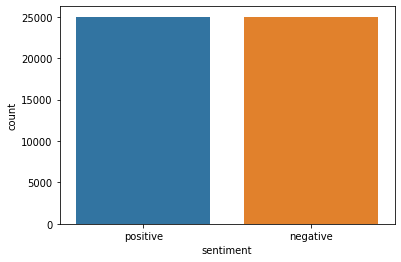

In [9]:
sns.countplot(x='sentiment', data=movie_reviews)

In [61]:
#balanced dataset, so we can use the accuracy as an evaluation metric.

In [62]:
#let's plot wordCloud to see the most used words

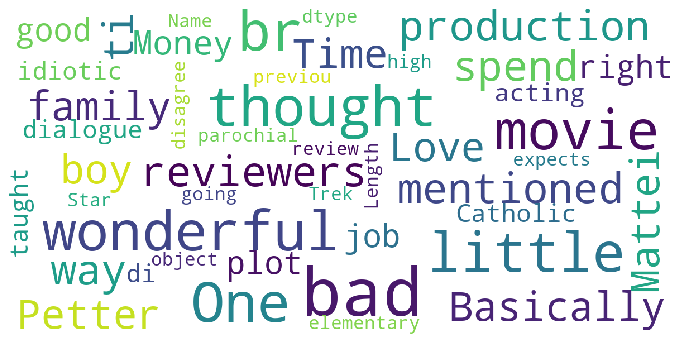

In [10]:

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(movie_reviews['review'])

<h2>Data Preprocessing</h2>

<ul>
<li>Removing html tags</li>
<li>Removing punctuations and numbers</li>
<li>Removing single character</li>
<li>Removing multiple spaces</li>
<li>Removing StopWords</li>
<li>lowercasing</li>
<li> Stemming</li>

</ul>

In [11]:
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Removing punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Lowercase
    sentence = sentence.lower() 
    
    # Removing StopWords
    sentence = ' '.join(word for word in sentence.split() if word not in STOPWORDS)
    
    # Stemming
    tokens = sentence .split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    sentence = ' '.join(tokens)
    
    return sentence


In [12]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [15]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))


In [16]:
print(X[1])

wonderful little production filming technique unassuming old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwell mural decorating every surface terribly well done


In [17]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [63]:
#train data = 70% 
#test data = 30% 

<h2> Preparing the Embedding Layer</h2>

In [19]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

GloVe, coined from Global Vectors, is a model for distributed word representation. The model is an unsupervised learning algorithm for obtaining vector representations for words. we used it for the embedding layer

In [22]:
embeddings_dictionary = dict()
glove_file = open(r'C:\Users\ASUS\Desktop\dev\dataset\IMDB\glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [23]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

<h2>Convolutional Neural Network</h2>

In [17]:
start_time = time.time()
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu', input_shape=(None,64,1)))
model.add(Conv1D(128,5, strides=1, activation='relu',padding='causal'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.15))
model.add(GaussianNoise(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
print("Temps d execution : %s secondes ---" % (time.time() - start_time))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          8752500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 128)              

In [18]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))


15000/15000 [==============================] - 3s 213us/step
Test set
  Loss: 0.381
  Accuracy: 0.8347


In [19]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8931


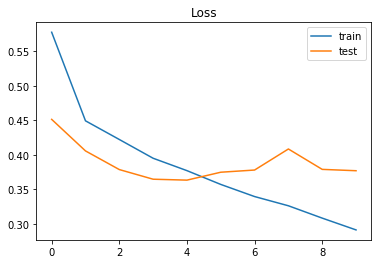

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

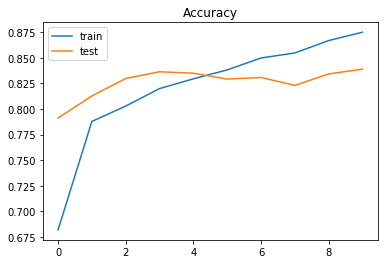

In [21]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

We achieved a high accuracy percentage but the model is overfeting! 

<h2> LSTM Model </h2>

In [29]:
start_time = time.time()
model2 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model2.add(embedding_layer)
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(128))
model2.add(GaussianNoise(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model2.summary())
history = model2.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

print("Temps d execution : %s secondes ---" % (time.time() - start_time))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          7877700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 7,995,077
Trainable params: 117,377
Non-trainable params: 7,877,700
_________________________________________________________________
None
Train on 28000 samples, validate on 7000 samples
Epoch 1/10
28000/28000 [==========================

In [30]:
accr = model2.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

15000/15000 [==============================] - 11s 715us/step
Test set
  Loss: 0.331
  Accuracy: 0.8549


In [64]:
# higher accuracy than the CNN model

In [31]:
loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8734


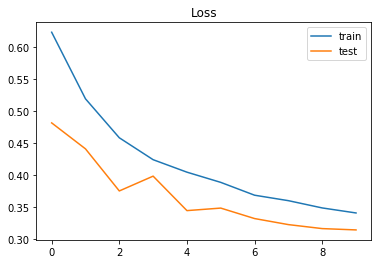

In [32]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

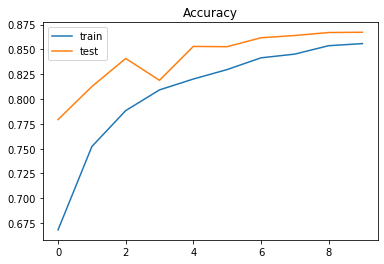

In [33]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [40]:
model2.save('basic_lstm.h5')

In [ ]:
#the model is not overfitting, let's use k-fold cross-validation to evaluate more the model

<h2>LSTM + k-fold cross-validation</h2>

That k-fold cross validation is a procedure used to estimate the skill of the model on new data. K-Fold CV is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point. 

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

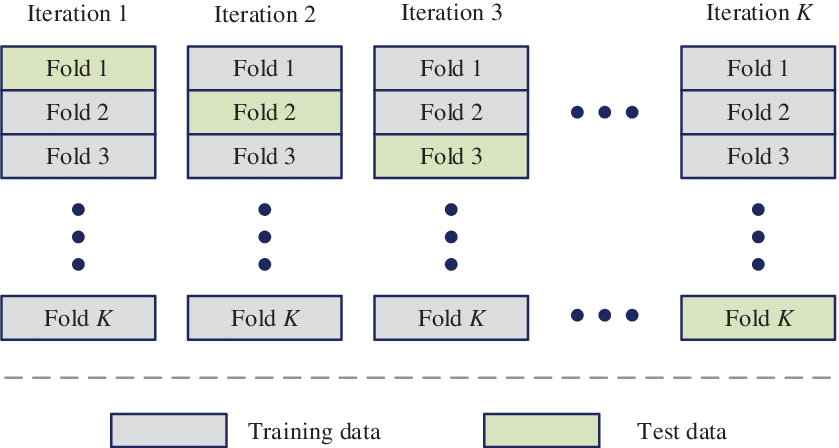

In [69]:
from IPython.display import Image
Image(r"C:\Users\ASUS\Desktop\K-fold-cross-validation-method.png")

In [70]:
#We used K equal to 3.

In [43]:
def create_model():
    model4=Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model4.add(embedding_layer)
    model4.add(SpatialDropout1D(0.2))
    model4.add(LSTM(128))
    model4.add(GaussianNoise(0.5))
    model4.add(Dense(1, activation='sigmoid'))
    model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model4




In [44]:
seed = 7
model4 = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=1)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(model4, X_train, y_train, cv=kfold)
print(results.mean())



Epoch 1/10
23333/23333 [==============================] - 27s 1ms/step - loss: 0.6574 - acc: 0.6313
Epoch 2/10
23333/23333 [==============================] - 31s 1ms/step - loss: 0.6071 - acc: 0.6975
Epoch 3/10
23333/23333 [==============================] - 31s 1ms/step - loss: 0.5439 - acc: 0.7361
Epoch 4/10
23333/23333 [==============================] - 31s 1ms/step - loss: 0.4670 - acc: 0.7836
Epoch 5/10
23333/23333 [==============================] - 31s 1ms/step - loss: 0.4266 - acc: 0.8107
Epoch 6/10
23333/23333 [==============================] - 31s 1ms/step - loss: 0.4140 - acc: 0.8167
Epoch 7/10
23333/23333 [==============================] - 31s 1ms/step - loss: 0.4013 - acc: 0.8217
Epoch 8/10
23333/23333 [==============================] - 31s 1ms/step - loss: 0.3829 - acc: 0.8311
Epoch 9/10
23333/23333 [==============================] - 31s 1ms/step - loss: 0.3795 - acc: 0.8342
Epoch 10/10
11667/11667 [==============================] - 5s 428us/step
Epoch 1/10
23333/23333 [===

In [65]:
#we achieved a good accuracy percentage which means that the model performed well with different test data.

<h2>biLSTM Model</h2>

A bidirectional LSTM (BiLSTM) layer learns bidirectional long-term dependencies between time steps of time series or sequence data. These dependencies can be useful when you want the network to learn from the complete time series at each time step.



In [66]:
#we used the same layers as the LSTM model.

In [59]:
start_time = time.time()
model3 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model3.add(embedding_layer)
model3.add(SpatialDropout1D(0.2))
model3.add(Bidirectional(LSTM(128)))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model2.summary())
history = model3.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

print("Temps d execution : %s secondes ---" % (time.time() - start_time))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          8752500   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 8,869,877
Trainable params: 117,377
Non-trainable params: 8,752,500
_________________________________________________________________
None
Train on 28000 samples, validate on 7000 samples
Epoch 1/10
28000/28000 [==============================] - 82s 3ms/step - loss: 0.5952 - acc: 0.6772 - val_loss: 0.4809 - val_acc: 0.7744
Epoch 2/10
28000/28000 [=====================

In [60]:
accr = model3.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

15000/15000 [==============================] - 16s 1ms/step
Test set
  Loss: 0.338
  Accuracy: 0.8460


In [61]:
loss, accuracy = model3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8787


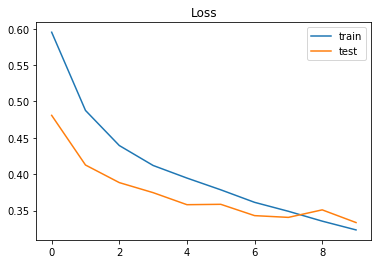

In [62]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

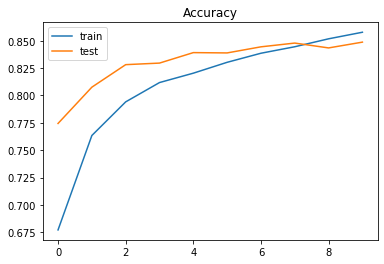

In [63]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [67]:
#Good accuracy percentage
#No overfitting 